In [1]:
import numpy as np
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
from utility.training import get_data_loader, scale_data, split_time_event
from utility.config import load_config
from utility.loss import CoxPHLoss
import paths as pt
from utility.survival import compute_survival_times
from utility.model import load_mlp_model, load_mlp_alea_model, load_vi_model, load_vi_epi_model, load_mcd_model
import math
from utility.survival import coverage
import torch
from utility.model import load_sota_model
import pandas as pd
from sklearn.model_selection import train_test_split
from utility.training import get_data_loader, scale_data, split_time_event
from utility.survival import survival_probability_calibration
from utility.model import load_mlp_model, load_sota_model, load_mcd_model, load_sngp_model, load_vi_model
from utility.survival import compute_nondeterministic_survival_curve, compute_deterministic_survival_curve
from utility.plot import plot_calibration_curves
from collections import defaultdict
from pathlib import Path
import paths as pt
from utility.survival import make_time_bins, calculate_event_times
from tools.preprocessor import Preprocessor
from utility.survival import (calculate_event_times, calculate_percentiles, convert_to_structured,
                              compute_deterministic_survival_curve, compute_nondeterministic_survival_curve)
from utility.training import make_stratified_split
from tools.evaluator import LifelinesEvaluator
from tools.Evaluations.util import predict_median_survival_time

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

N_SAMPLES_TRAIN = 10
N_SAMPLES_TEST = 1000

c:\Users\au475271\Miniconda3\envs\py39-baysurv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
dataset_name = "METABRIC"
dl = get_data_loader(dataset_name).load_data()
num_features, cat_features = dl.get_features()
df = dl.get_data()

# Split data
df_train, df_valid, df_test = make_stratified_split(df, stratify_colname='both', frac_train=0.7,
                                                    frac_valid=0.1, frac_test=0.2, random_state=0)
X_train = df_train[cat_features+num_features]
X_valid = df_valid[cat_features+num_features]
X_test = df_test[cat_features+num_features]
y_train = convert_to_structured(df_train["time"], df_train["event"])
y_test = convert_to_structured(df_test["time"], df_test["event"])

# Scale data
X_train, X_valid, X_test = scale_data(X_train, X_valid, X_test, cat_features, num_features)

# Convert to array
X_train = np.array(X_train)
X_test = np.array(X_test)

# Make time/event split
t_train, e_train = split_time_event(y_train)
t_test, e_test = split_time_event(y_test)

# Make event times
event_times = calculate_event_times(t_train, e_train)

# Load models
n_input_dims = X_train.shape[1:]
n_train_samples = X_train.shape[0]
cox_model = load_sota_model(dataset_name, "cox")
mlp_model = load_mlp_model(dataset_name, n_input_dims)
sngp_model = load_sngp_model(dataset_name, n_input_dims)
vi_model = load_vi_model(dataset_name, len(X_train), n_input_dims)
mcd_model1 = load_mcd_model(dataset_name, "mcd1", n_input_dims)
mcd_model2 = load_mcd_model(dataset_name, "mcd2", n_input_dims)
mcd_model3 = load_mcd_model(dataset_name, "mcd3", n_input_dims)

c:\Users\au475271\Miniconda3\envs\py39-baysurv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


c:\Users\au475271\Miniconda3\envs\py39-baysurv\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
c:\Users\au475271\Miniconda3\envs\py39-baysurv\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [3]:
# Compute variance on the test set
runs = 100
model_vars = dict()
model_names = ["vi", "mcd1", "mcd2", "mcd3"]
models = [vi_model, mcd_model1, mcd_model2, mcd_model3]
for model, model_name in zip(models, model_names):
    logits_cpd = np.zeros((runs, len(X_test)), dtype=np.float32)
    for i in range(0, runs):
        logits_cpd[i,:] = np.reshape(model(X_test, training=False).sample(), len(X_test))
    mean_std = np.mean(tf.math.reduce_std(logits_cpd, axis=0, keepdims=True))
    model_vars[model_name] = mean_std ** 2
model_vars

{'vi': 1.2693079344078484,
 'mcd1': 0.32348187806405804,
 'mcd2': 0.20242701294173404,
 'mcd3': 0.1887394228850816}

In [4]:
# Calculate survival probs
surv_times = compute_nondeterministic_survival_curve(mcd_model3, X_train, X_test, e_train, t_train, event_times, N_SAMPLES_TRAIN, N_SAMPLES_TEST)
median_outputs = pd.DataFrame(np.mean(surv_times, axis=0), columns=event_times)

# Calculate TTE
lifelines_eval = LifelinesEvaluator(median_outputs.T, t_test, e_test, t_train, e_train)
median_survival_time = lifelines_eval.predict_time_from_curve(predict_median_survival_time)

In [5]:
# Compute 90% credible interval of ith individual
sample_idx = 9
sample_tte = t_test[sample_idx]
sample_surv_times = surv_times[:,sample_idx,:]
sample_median_survival_time = median_survival_time[sample_idx]
drop_num = math.floor(0.5 * N_SAMPLES_TEST * (1 - 0.9))
mean_outputs = np.mean(sample_surv_times, axis=0)
lower_outputs = torch.kthvalue(torch.from_numpy(sample_surv_times), k=1 + drop_num, dim=0)[0]
upper_outputs = torch.kthvalue(torch.from_numpy(sample_surv_times), k=N_SAMPLES_TEST - drop_num, dim=0)[0]

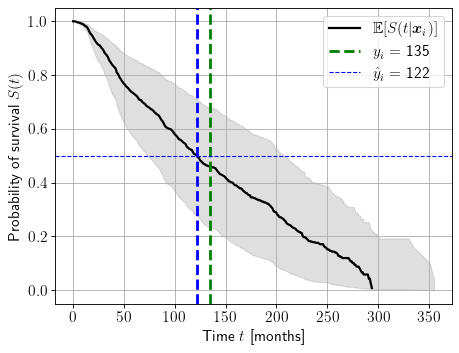

In [6]:
matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})
plt.figure(dpi=80)
plt.plot(mean_outputs, linewidth=2, label=r"$\mathbb{E}[S(t|\bm{x}_{i})]$", color="black")
plt.fill_between(event_times, upper_outputs, lower_outputs, color="gray", alpha=0.25)
plt.axvline(x=sample_tte, linestyle="dashed", color='green', linewidth=2.5, label=f'$y_i$ = {int(sample_tte)}')
plt.axhline(y=0.5, linestyle= "dashed", color='blue', linewidth=1, label='$\hat{y}_{i}$ = ' + f'{int(sample_median_survival_time)}')   
plt.axvline(x=int(sample_median_survival_time), linestyle= "dashed", color='blue', linewidth=2.5)
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$ [months]")
plt.legend()
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"metabric_cri.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

In [7]:
X_test_sample = X_test[sample_idx,:]
X_test_sample = np.expand_dims(X_test_sample, axis=0)
surv_times = compute_nondeterministic_survival_curve(mcd_model3, X_train, X_test_sample, e_train, t_train, event_times, N_SAMPLES_TRAIN, N_SAMPLES_TEST)
sample_median_outputs = pd.DataFrame(np.mean(surv_times, axis=1), columns=event_times)
lifelines_eval = LifelinesEvaluator(sample_median_outputs.T, t_test, e_test, t_train, e_train)
sample_median_survival_times = lifelines_eval.predict_time_from_curve(predict_median_survival_time)

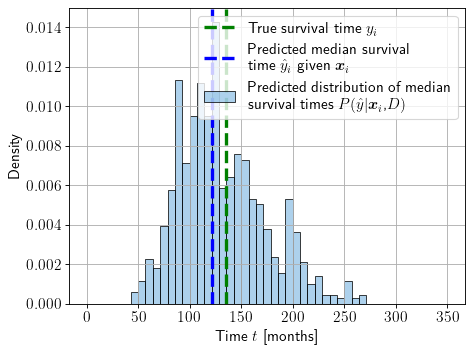

In [8]:
import seaborn as sns
HIST_BINS = np.linspace(0, 350, 50)
plt.figure(dpi=80)
plt.axvline(x=sample_tte, color='g', linewidth=3, label="True survival time ${y}_{i}$", linestyle="dashed")
sns.histplot(sample_median_survival_times, bins=HIST_BINS, color=TFColor[3],
             label="Predicted distribution of median \n survival times $P(\hat{y}|$" + r"$\bm{x}_{i}$," + "$D)$", alpha=0.5, stat="density")
plt.axvline(x=int(sample_median_survival_time), color='b', linewidth=3, linestyle="dashed",
            label="Predicted median survival \n time $\hat{y}_{i}$ given " + r"$\bm{x}_{i}$")
plt.xlabel("Time $t$ [months]")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"metabric_cpd.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

In [9]:
# Calculate survival probs
surv_times = compute_nondeterministic_survival_curve(vi_model, X_train, X_test, e_train, t_train, event_times, N_SAMPLES_TRAIN, N_SAMPLES_TEST)
median_outputs = pd.DataFrame(np.mean(surv_times, axis=0), columns=event_times)

# Calculate TTE
lifelines_eval = LifelinesEvaluator(median_outputs.T, t_test, e_test, t_train, e_train)
median_survival_time = lifelines_eval.predict_time_from_curve(predict_median_survival_time)

In [10]:
# Compute 90% credible interval of ith individual
sample_idx = 9
sample_tte = t_test[sample_idx]
sample_surv_times = surv_times[:,sample_idx,:]
sample_median_survival_time = median_survival_time[sample_idx]
drop_num = math.floor(0.5 * N_SAMPLES_TEST * (1 - 0.9))
mean_outputs = np.mean(sample_surv_times, axis=0)
lower_outputs = torch.kthvalue(torch.from_numpy(sample_surv_times), k=1 + drop_num, dim=0)[0]
upper_outputs = torch.kthvalue(torch.from_numpy(sample_surv_times), k=N_SAMPLES_TEST - drop_num, dim=0)[0]

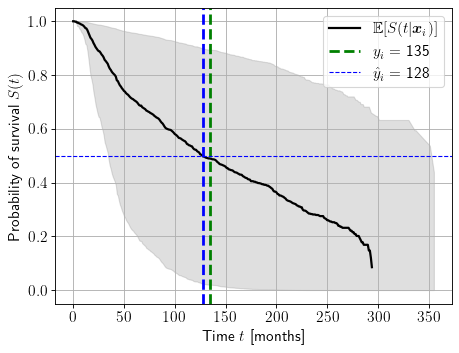

In [11]:
matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})
plt.figure(dpi=80)
plt.plot(mean_outputs, linewidth=2, label=r"$\mathbb{E}[S(t|\bm{x}_{i})]$", color="black")
plt.fill_between(event_times, upper_outputs, lower_outputs, color="gray", alpha=0.25)
plt.axvline(x=sample_tte, linestyle="dashed", color='green', linewidth=2.5, label=f'$y_i$ = {int(sample_tte)}')
plt.axhline(y=0.5, linestyle= "dashed", color='blue', linewidth=1, label='$\hat{y}_{i}$ = ' + f'{int(sample_median_survival_time)}')   
plt.axvline(x=int(sample_median_survival_time), linestyle= "dashed", color='blue', linewidth=2.5)
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$ [months]")
plt.legend()
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"metabric_cri_vi.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()

In [12]:
X_test_sample = X_test[sample_idx,:]
X_test_sample = np.expand_dims(X_test_sample, axis=0)
surv_times = compute_nondeterministic_survival_curve(vi_model, X_train, X_test_sample, e_train, t_train, event_times, N_SAMPLES_TRAIN, N_SAMPLES_TEST)
sample_median_outputs = pd.DataFrame(np.mean(surv_times, axis=1), columns=event_times)
lifelines_eval = LifelinesEvaluator(sample_median_outputs.T, t_test, e_test, t_train, e_train)
sample_median_survival_times = lifelines_eval.predict_time_from_curve(predict_median_survival_time)

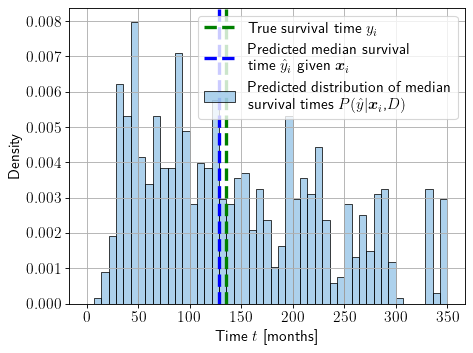

In [13]:
import seaborn as sns
HIST_BINS = np.linspace(0, 350, 50)
plt.figure(dpi=80)
plt.axvline(x=sample_tte, color='g', linewidth=3, label="True survival time ${y}_{i}$", linestyle="dashed")
sns.histplot(sample_median_survival_times, bins=HIST_BINS, color=TFColor[3],
             label="Predicted distribution of median \n survival times $P(\hat{y}|$" + r"$\bm{x}_{i}$," + "$D)$", alpha=0.5, stat="density")
plt.axvline(x=int(sample_median_survival_time), color='b', linewidth=3, linestyle="dashed",
            label="Predicted median survival \n time $\hat{y}_{i}$ given " + r"$\bm{x}_{i}$")
plt.xlabel("Time $t$ [months]")
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig(Path.joinpath(pt.RESULTS_DIR, f"metabric_cpd_vi.pdf"),
            format='pdf', bbox_inches="tight")
plt.show()
plt.close()